# Trabalho Prático 2
Produção de Petróleo e gás natural nacional

# 2. Membros (nome e número de matrícula)
- Elias Maxwell de Jesus Fialho
- Paula D'Agostini Alvares Maciel
- Pedro Bernardo Goulart Parreira
- Rubens da Cunha Castro

# 3. Descrição dos dados

Utilizaremos o banco de dados entitulado "Produção de petróleo e gás natural nacional" da Agência Nacional do Petróleo, Gás Natural e Biocombustíveis - ANP disponibilizado em https://dados.gov.br/dados/conjuntos-dados/produo-de-petrleo-e-gs-natural-nacional.

In [ ]:
import sqlite3, csv, os
from matplotlib import pyplot as plt

### Carregamento dos dados

Os dados estão sendo armazenados em uma pasta compactada no google drive; os extraímos utilizando o wget.

chave do arquivo: 1OrXRAG_iBdQaZu9mbXp1cpp60oqSzhcU

In [ ]:
!mkdir -p /tmp/arqs # cria o diretorio '/tmp/arqs' apenas caso nao exista
!wget --no-check-certificate '[local do arquivo]' -O "producao.zip"
!unzip producao.zip -d /tmp/arqs # extrai os arquivos baixados para o diretorio criado

--2023-11-21 23:39:30--  https://docs.google.com/uc?export=download&id=1OrXRAG_iBdQaZu9mbXp1cpp60oqSzhcU&confirm=t&uuid=c0602894-7f95-44c4-806f-5b3a774ef799&at=AGIUDvpCa1WsngCYPRoLUJxmcxOt:1698527714553
Resolving docs.google.com (docs.google.com)... 172.253.62.139, 172.253.62.101, 172.253.62.138, ...
Connecting to docs.google.com (docs.google.com)|172.253.62.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/06q150gaequkqotmeghi4977nmb2egca/1700609925000/16054867499610661374/*/1OrXRAG_iBdQaZu9mbXp1cpp60oqSzhcU?e=download&uuid=c0602894-7f95-44c4-806f-5b3a774ef799 [following]
--2023-11-21 23:39:30--  https://doc-0s-a8-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/06q150gaequkqotmeghi4977nmb2egca/1700609925000/16054867499610661374/*/1OrXRAG_iBdQaZu9mbXp1cpp60oqSzhcU?e=download&uuid=c0602894-7f95-44c4-806f-5b3a774ef799
Resolving doc-0s-

Aqui definimos os trechos de código responsáveis por:


1.   Criar as tabelas do banco seguindo o Diagrama Relacional
2.   Processar os arquivos e colocar os dados em forma conveniente para inserção
3.   Inserir os dados nas tabelas criadas.

Os arquivos providenciados variavam em codificação e possuíam linhas mal formatadas que foram devidamente tratadas.
Não obstante, em (2), sequencialmente lemos todos os arquivos e armazenamos suas linhas em tabelas temporárias a fim de facilitar a criação do Banco De Dados e delegar possíveis otimizações ao SGBD.

Por fim, em (3) realizamos a inserção dos dados armazenados em tabelas temporárias utilizando consultas sql para que tenham a estrutura desejada.

#### Definição de funções auxiliares

In [ ]:
def get_filenames(pasta: str):
  arquivos = []
  for arquivo in os.listdir(pasta):
    if os.path.isfile(os.path.join(pasta, arquivo)):
      arquivos.append(arquivo)
  return arquivos


# passa por todos os arquivos do diretório dado e tenta abrir-los com duas
# codificações diferentes. Caso a codificação levante
# um erro, imprime o nome do arquivo anômalo.
def treated_open(filename: str):
  try:
    file = open(filename, encoding='utf-8')
    file.readline(1)
    file.seek(0)
    return file

  except UnicodeDecodeError:
    try:
      return open(filename, encoding='cp1252')

    except:
      print(f"erro: {filename}")


def create_db(cursor: sqlite3.Cursor):
  cursor.execute("""
  CREATE TABLE Estruturas (
    uf Text,
    bacia Text,
    campo Text,
    poco Text,
    ambiente Text,
    instalacao Text,
    PRIMARY KEY (uf, bacia, campo, poco, ambiente, instalacao)

  );
  """)


  cursor.execute("""
  CREATE TABLE Poco (
    id_poco INTEGER PRIMARY KEY NOT NULL,
    nome_poco TEXT NOT NULL,
    ambiente_poco TEXT NOT NULL,
    instal_poco TEXT NOT NULL,
    id_campo,
    id_estado,
    FOREIGN KEY (id_campo) REFERENCES Campo(id_campo),
    FOREIGN KEY (id_estado) REFERENCES Estado(id_estado)
  );
  """)

  cursor.execute("""
  CREATE TABLE ProducaoTemp (
    data_prod TEXT,
    nome_prod TEXT,
    oleo_prod REAL,
    cond_prod REAL,
    gas_assoc_prod REAL,
    gas_n_assoc_prod REAL,
    agua_prod REAL,
    gas_inj_prod REAL,
    agua_rec_inj_prod REAL,
    agua_desc_inj_prod REAL,
    co2_inj_prod REAL,
    nitro_inj_prod REAL,
    vapor_inj_prod REAL,
    polimero_inj_prod REAL,
    outros_inj_prod REAL,
    PRIMARY KEY (data_prod, nome_prod)
  );
  """)

  cursor.execute("""
  CREATE TABLE Producao (
    data_prod TEXT,
    id_poco INTEGER,
    oleo_prod REAL,
    cond_prod REAL,
    gas_assoc_prod REAL,
    gas_n_assoc_prod REAL,
    agua_prod REAL,
    gas_inj_prod REAL,
    agua_rec_inj_prod REAL,
    agua_desc_inj_prod REAL,
    co2_inj_prod REAL,
    nitro_inj_prod REAL,
    vapor_inj_prod REAL,
    polimero_inj_prod REAL,
    outros_inj_prod REAL,
    FOREIGN KEY (id_poco) REFERENCES Poco(id_poco),
    PRIMARY KEY (data_prod, id_poco)
  );
  """)

  cursor.execute("""
  CREATE TABLE Estado (
    id_estado Integer PRIMARY KEY,
    nome_estado Text
  );
  """)

  cursor.execute("""
  CREATE TABLE Bacia (
    id_bacia Integer PRIMARY KEY, nome_bacia
  );
  """)

  cursor.execute("""
  CREATE TABLE Campo (
    id_campo Integer PRIMARY KEY,
    nome_campo, id_bacia,
    FOREIGN KEY (id_bacia) REFERENCES Bacia(id_bacia)
  );
  """)



def split_string(string):
  line = csv.reader([string], skipinitialspace=True)
  return next(line)


def db_feeder(file, cursor: sqlite3.Cursor):
  cursor.execute("PRAGMA foreign_keys=0;")
  r = csv.reader(file, delimiter=',', quotechar='"')
  next(r)  # pula a header
  for row in r:
    # algumas linhas são uma string gigante ao invés de estarem separadas
    # se for o caso, separo elas por virgula e sigo normalmente
    # parece que é possível supor que a separação por vírgula é correta ao menos
    try:
      # forçando acesso a um indice que pode não existir para cair no erro
      row[2]

    except IndexError:
      row = split_string(row[0])

    # formata as linhas para o sql
    struct_values = map(lambda s: f'"{s}"', row[2:8])
    struct_values = ', '.join(struct_values)

    standardized_date = row[1].split('/')
    standardized_date = f"{standardized_date[1]}-{standardized_date[0]}"

    numericals = ' '.join(map(lambda x: '0' if x == '' else x, row[8:])).replace(',', '.').replace(' ', ',')

    query = f"INSERT OR IGNORE INTO Estruturas VALUES ({struct_values});"
    cursor.execute(query)

    query = f"""INSERT OR IGNORE INTO ProducaoTemp VALUES (
      '{standardized_date}',
      '{row[5]}',
      {numericals}
    );"""

    #print(query)
    cursor.execute(query)


def feed_tables(cursor: sqlite3.Cursor):
  cursor.execute("""
  INSERT INTO Estado (nome_estado)
  SELECT DISTINCT
    uf
  FROM Estruturas;
  """)

  cursor.execute("""
  INSERT INTO Bacia (nome_bacia)
  SELECT DISTINCT bacia
  FROM Estruturas
  """)

  cursor.execute("""
  INSERT INTO Campo (nome_campo, id_bacia)
  SELECT DISTINCT campo, id_bacia
  FROM
    Estruturas
    JOIN Estado ON
      Estruturas.uf = Estado.nome_estado
    JOIN Bacia ON
      Estruturas.bacia = Bacia.nome_bacia
      AND Estruturas.uf = Estado.nome_estado;
  """)

  cursor.execute("""
  INSERT INTO Poco (nome_poco, id_campo, ambiente_poco, instal_poco, id_estado)
  SELECT DISTINCT poco, Campo.id_campo, ambiente, instalacao, Estado.id_estado
  FROM
    Estruturas
    JOIN Estado ON Estruturas.uf = Estado.nome_estado
    JOIN Bacia ON Bacia.nome_bacia = Estruturas.bacia
    JOIN Campo ON Campo.id_bacia = Bacia.id_bacia
      AND Campo.nome_campo = Estruturas.campo;
  """)

  cursor.execute("""
  INSERT OR IGNORE INTO Producao
  SELECT
    data_prod,
    id_poco,
    oleo_prod,
    cond_prod,
    gas_assoc_prod,
    gas_n_assoc_prod,
    agua_prod,
    gas_inj_prod,
    agua_rec_inj_prod,
    agua_desc_inj_prod,
    co2_inj_prod,
    nitro_inj_prod,
    vapor_inj_prod,
    polimero_inj_prod,
    outros_inj_prod
  FROM
    ProducaoTemp INNER JOIN Poco
    ON ProducaoTemp.nome_prod = Poco.nome_poco

  """)

#### Alimentação do banco de dados



In [ ]:
!rm -f /tmp/producao.db  # reseta o bd caso exista
conn = sqlite3.connect('/tmp/producao.db')
cursor = conn.cursor()

print('Comprando ações da Petrobrás...')
create_db(cursor)

for dir in ('/tmp/arqs/producao/terra/', '/tmp/arqs/producao/mar/'):
  for filename in get_filenames(dir):
    file = treated_open(dir + filename)
    db_feeder(file, cursor)
    file.close()

print('Perfurando Poços...')
feed_tables(cursor)
print('Banco de Dados criado')



Comprando ações da Petrobrás...
Perfurando Poços...
Banco de Dados criado


# 4. Diagrama ER

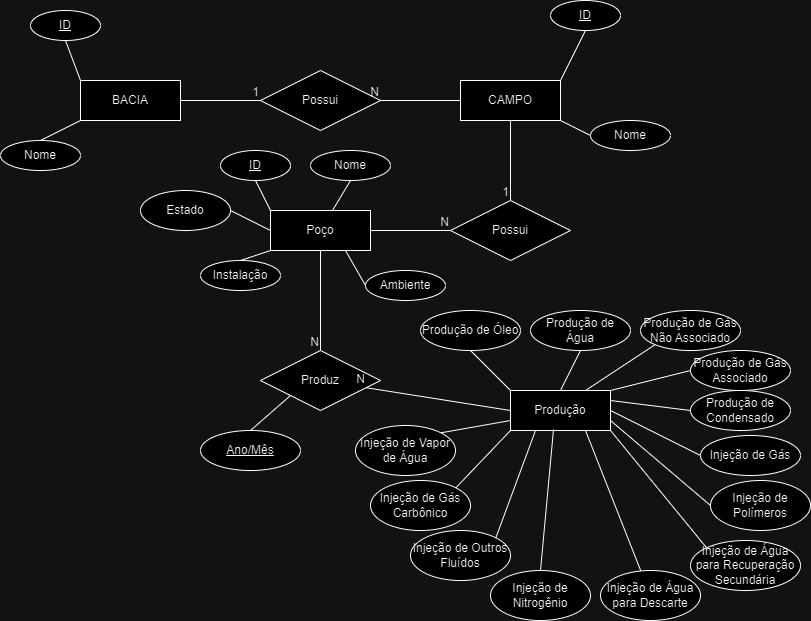

# 5. Diagrama relacional

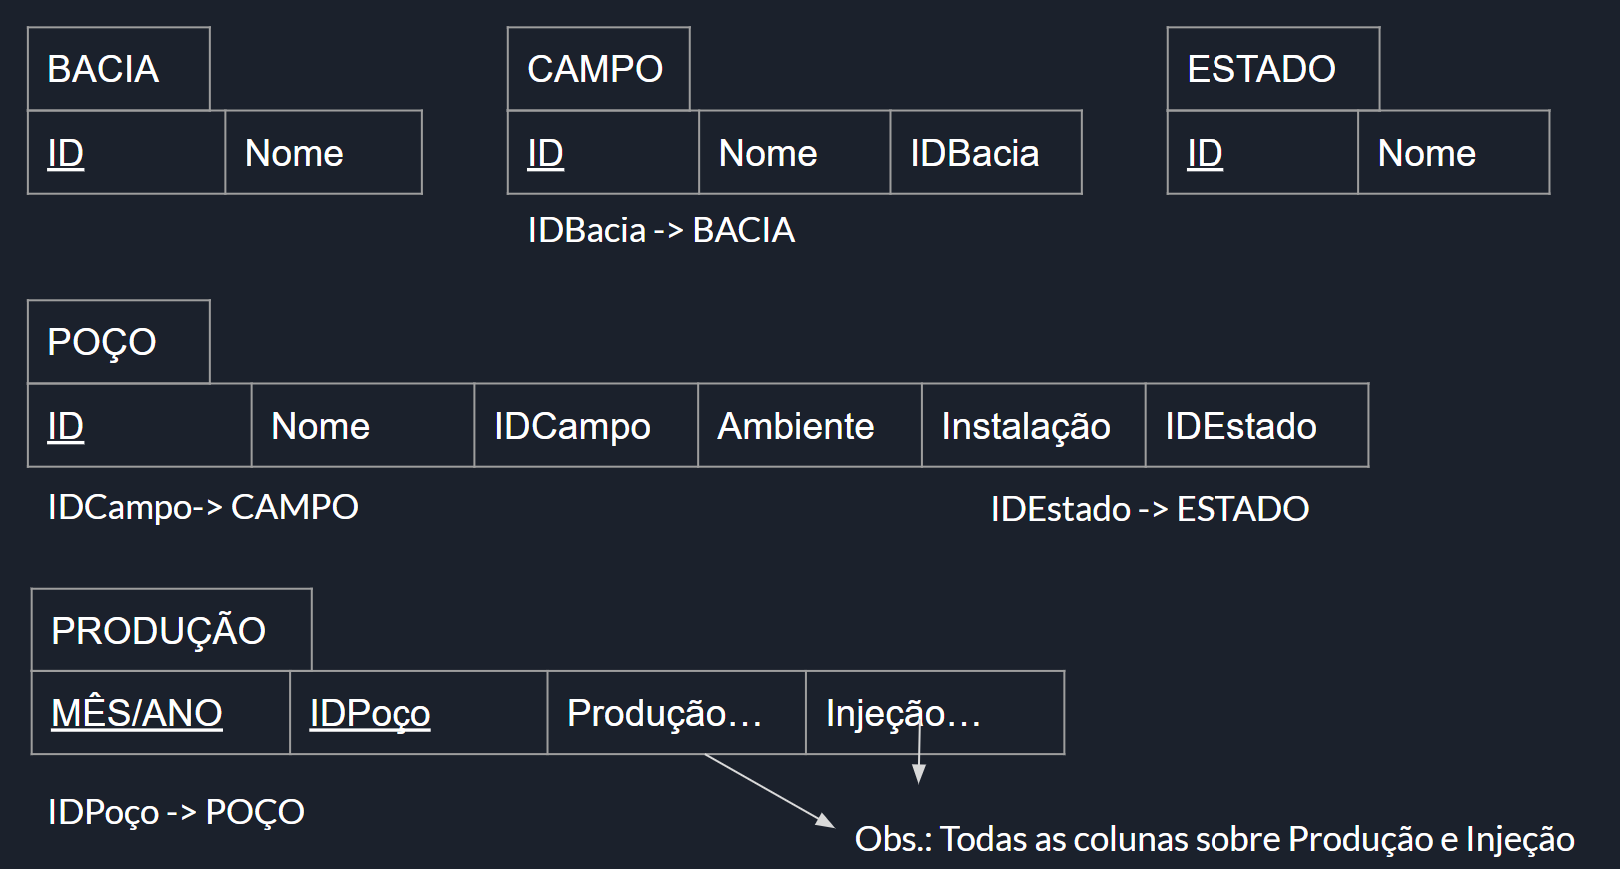

# 6. Consultas

## 6.1 Duas consultas envolvendo seleção e projeção

### 6.1.1 Consulta 1


Nome do poço e data em que houve maior injeção de polímero de todos os tempos

In [ ]:
a = cursor.execute("""
SELECT
      nome_poco,
      data_prod AS ANO
FROM Producao as PR, Poco as P
WHERE polimero_inj_prod = (
    SELECT MAX(polimero_inj_prod)
    FROM Producao
) AND PR.id_poco = P.id_poco;

""")
for row in a:
  print(row)

('8-PRG-36H-RJS', '2019-09')


### 6.1.2 Consulta 2

meses em que houveram injeção de polímero e gás maiores que 3 milhões

In [ ]:
a = cursor.execute("""
SELECT
    data_prod AS ANO
FROM Producao
GROUP BY data_prod
HAVING SUM(gas_inj_prod + polimero_inj_prod) > 3000000;
""")
for row in a:
  print(row)

('2015-04',)
('2015-07',)
('2015-08',)
('2015-10',)
('2015-11',)
('2015-12',)
('2016-01',)
('2016-02',)
('2016-03',)
('2016-05',)
('2016-06',)
('2016-07',)
('2016-08',)
('2016-09',)
('2016-10',)
('2016-11',)
('2016-12',)
('2017-01',)
('2017-02',)
('2017-03',)
('2017-04',)
('2017-05',)
('2017-06',)
('2017-07',)
('2017-08',)
('2017-09',)
('2017-10',)
('2017-11',)
('2017-12',)
('2018-01',)
('2018-02',)
('2018-03',)
('2018-04',)
('2018-05',)
('2018-06',)
('2018-07',)
('2018-08',)
('2018-09',)
('2018-10',)
('2018-11',)
('2018-12',)
('2019-01',)
('2019-02',)
('2019-03',)
('2020-03',)
('2020-07',)
('2020-08',)
('2020-09',)
('2020-10',)
('2021-01',)
('2021-03',)
('2021-04',)
('2021-05',)
('2021-07',)


## 6.2 Três consultas envolvendo junção de duas relações

### 6.2.1 Consulta 3
Estados que mais fizeram uso de tecnicas de recuperação para poços de alta viscosidade. Espera-se evidenciar a localização do pré-sal.

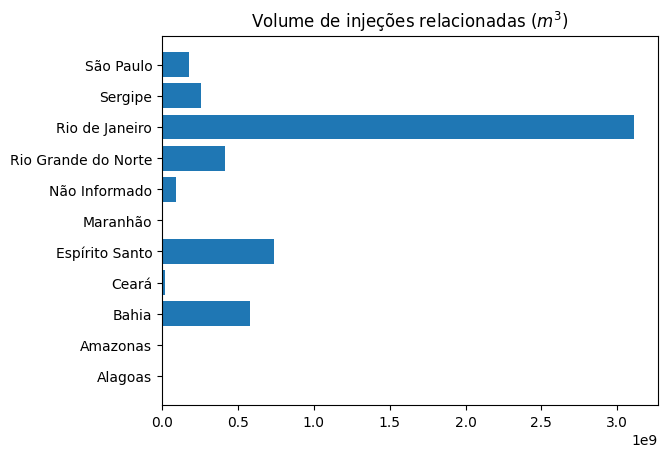

('Alagoas', 7608739.8728200365)
('Amazonas', 0.0)
('Bahia', 578997213.5542681)
('Ceará', 21215639.593629915)
('Espírito Santo', 735250230.2028474)
('Maranhão', 0.0)
('Não Informado', 92797488.31864342)
('Rio Grande do Norte', 411655921.7330009)
('Rio de Janeiro', 3113670555.2021685)
('Sergipe', 254861785.50390875)
('São Paulo', 174325915.18354663)


In [ ]:
a = cursor.execute("""
SELECT
   nome_estado,
   SUM((vapor_inj_prod/1000) + (co2_inj_prod/1000) + agua_rec_inj_prod) as injecoes_viscosidade
FROM
  Producao NATURAL JOIN Poco
  NATURAL JOIN Estado
WHERE data_prod > 2012
GROUP BY nome_estado
""")
a = list(a)
plt.title("Volume de injeções relacionadas ($m^3$)")
plt.barh([t[0] for t in a], [t[1] for t in a])
plt.show()


for row in a:
  print(row)

### 6.2.2 Consulta 4

Quantos poços cada estado possui

In [ ]:
a = cursor.execute("""
SELECT
    E.nome_estado,
    COUNT(P.id_poco) AS qtdPoços
FROM Poco P
NATURAL JOIN Estado E
GROUP BY E.nome_estado;
""")
for row in a:
  print(row)

('Alagoas', 786)
('Amazonas', 259)
('Bahia', 8812)
('Ceará', 1758)
('Espírito Santo', 2039)
('Maranhão', 102)
('Não Informado', 113)
('Paraná', 10)
('Rio Grande do Norte', 13680)
('Rio de Janeiro', 3879)
('Santa Catarina', 1)
('Sergipe', 6378)
('São Paulo', 225)


### 6.2.3 Consulta 5

Comparação entre a produção de Gás Associado e Não Associado dos poços terrestres e marítimos.

In [ ]:
a = cursor.execute("""
SELECT DISTINCT
  ambiente_poco, sum(gas_assoc_prod), sum(gas_n_assoc_prod)
FROM
  Poco NATURAL JOIN Producao
GROUP BY ambiente_poco;
""")
for row in a:
  print(row)

('Mar', 1120704780.5452886, 197760067.30195186)
('Terra', 250897557.29688722, 98503212.23792106)


## 6.3 Três consultas envolvendo junção de três ou mais relações

### 6.3.1 Consulta 6
5 campos de petróleo(e seus respectivos estados) com a maior produção nos últimos 10 anos


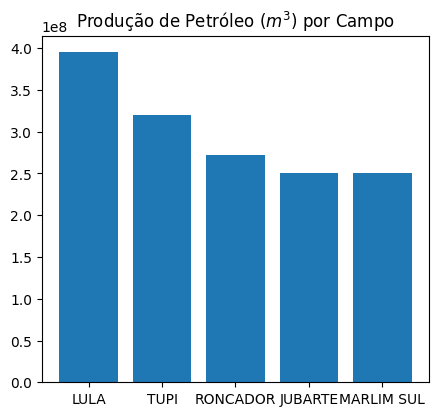

('LULA', 395081827.06683934, 'Rio de Janeiro')
('TUPI', 320213947.00195795, 'Rio de Janeiro')
('RONCADOR', 271985135.87800014, 'Rio de Janeiro')
('JUBARTE', 251098815.96500084, 'Espírito Santo')
('MARLIM SUL', 250772174.88788137, 'Rio de Janeiro')


In [ ]:
a = cursor.execute("""
SELECT nome_campo, SUM(oleo_prod) as prod, nome_estado
FROM Producao
NATURAL JOIN Poco
NATURAL JOIN Estado
NATURAL JOIN Campo
WHERE data_prod > 2012
GROUP BY nome_campo
ORDER BY prod DESC
LIMIT 5
""")
a = list(a)
plt.title("Produção de Petróleo ($m^3$) por Campo")
plt.bar([t[0] for t in a], [t[1] for t in a])
plt.show()

for row in a:
  print(row)

### 6.3.2 Consulta 7

Nome da bacia, do poço, do ambiente do poço e todas as quantidades de produção de gás associado do estado de Alagoas.

In [ ]:
a = cursor.execute("""
WITH EstadoMaisProdutor AS (
    SELECT
        E.id_estado,
        E.nome_estado AS ESTADO,
        COUNT(DISTINCT P.id_poco) AS QTD_POÇOS,
        SUM(PR.agua_prod) AS TOTAL_AGUA_PROD
    FROM Estado E
    NATURAL JOIN Poco P
    NATURAL JOIN Producao PR
    WHERE PR.data_prod BETWEEN '2020-01-01' AND '2021-12-31'
    GROUP BY
        E.nome_estado
    ORDER BY
        TOTAL_AGUA_PROD DESC
    LIMIT 1
)

-- Informações sobre o estado mais produtivo
SELECT
    EM.ESTADO,
    EM.QTD_POÇOS AS QTD_POÇOS_ESTADO,
    EM.TOTAL_AGUA_PROD AS TOTAL_AGUA_PROD_ESTADO,
    P.nome_poco AS POÇO,
    SUBSTR(PR.data_prod, 1, 4) AS ANO,
    SUM(PR.agua_prod) AS PRODUCAO_AGUA
FROM
    EstadoMaisProdutor EM
NATURAL JOIN Poco P
NATURAL JOIN Producao PR
WHERE  PR.data_prod BETWEEN '2020-01-01' AND '2021-12-31'
GROUP BY
    EM.ESTADO,
    EM.QTD_POÇOS,
    EM.TOTAL_AGUA_PROD,
    P.nome_poco,
    SUBSTR(PR.data_prod, 1, 4)
ORDER BY
    EM.TOTAL_AGUA_PROD DESC, PRODUCAO_AGUA DESC
LIMIT 3;
""")
for row in a:
  print(row)

('Rio de Janeiro', 2679, 206348272.25539133, '7-LL-45D-RJS', '2021', 4148601.923999999)
('Rio de Janeiro', 2679, 206348272.25539133, '9-BRSA-1099-RJS', '2020', 3215629.66104)
('Rio de Janeiro', 2679, 206348272.25539133, '9-BRSA-1099-RJS', '2021', 3031483.1012400007)


### 6.3.3 Consulta 8
Quantos campos cada bacia possui

In [ ]:
a = cursor.execute("""
SELECT
    B.id_bacia,
    B.nome_bacia,
    E.nome_estado,
    COUNT(C.id_campo)
FROM Bacia B
LEFT NATURAL JOIN Campo C
LEFT NATURAL JOIN Poco P
LEFT NATURAL JOIN ESTADO E
GROUP BY B.id_bacia, B.nome_bacia, E.nome_estado;
""")
for row in a:
  print(row)

(1, 'Alagoas', 'Alagoas', 786)
(1, 'Alagoas', 'Não Informado', 3)
(2, 'Solimões', 'Amazonas', 255)
(3, 'Mucuri', 'Bahia', 8)
(4, 'Recôncavo', 'Bahia', 8716)
(5, 'Tucano Sul', 'Bahia', 62)
(6, 'Potiguar', 'Ceará', 1583)
(6, 'Potiguar', 'Não Informado', 8)
(6, 'Potiguar', 'Rio Grande do Norte', 13680)
(6, 'Potiguar', 'Sergipe', 1)
(7, 'Espírito Santo', 'Espírito Santo', 1846)
(7, 'Espírito Santo', 'Não Informado', 4)
(8, 'Sergipe', 'Não Informado', 9)
(8, 'Sergipe', 'Sergipe', 6377)
(9, 'Camamu', 'Bahia', 24)
(10, 'Barreirinhas', 'Maranhão', 8)
(11, 'Parnaíba', 'Maranhão', 94)
(11, 'Parnaíba', 'Não Informado', 1)
(12, 'Amazonas', 'Amazonas', 4)
(12, 'Amazonas', 'Não Informado', 1)
(13, 'Ceará', 'Ceará', 175)
(14, 'Campos', 'Espírito Santo', 193)
(14, 'Campos', 'Rio de Janeiro', 2916)
(15, 'Santos', 'Não Informado', 87)
(15, 'Santos', 'Paraná', 10)
(15, 'Santos', 'Rio de Janeiro', 963)
(15, 'Santos', 'Santa Catarina', 1)
(15, 'Santos', 'São Paulo', 225)
(16, 'Jequitinhonha', 'Bahia', 2)


## 6.4 Duas consultas envolvendo agregação sobre junção de duas ou mais relações

### 6.4.1 Consulta 9

Poços que mais fizeram injeção de gás em cada mês apartir de maio de 2003

In [ ]:
 a = cursor.execute("""
WITH RankedProducao AS (
    SELECT
        PR.data_prod,
        PC.nome_poco,
        E.nome_estado,
        B.nome_bacia,
        PC.ambiente_poco,
        PR.gas_inj_prod AS PRODUCAO_GAS,
        ROW_NUMBER() OVER (PARTITION BY PR.data_prod ORDER BY PR.gas_inj_prod DESC) AS RowNum
    FROM Producao PR
    NATURAL JOIN Poco PC
    NATURAL JOIN Campo C
    NATURAL JOIN Bacia B
    NATURAL JOIN Estado E
    WHERE PR.data_prod >= '2003-05'
)
SELECT
    nome_poco,
    nome_estado,
    nome_bacia,
    ambiente_poco,
    PRODUCAO_GAS,
    count(nome_poco)
FROM RankedProducao
WHERE RowNum = 1
GROUP BY nome_poco
""")
for row in a:
  print(row)

('1-LUC-1-AM', 'Amazonas', 'Solimões', 'Terra', 30178.0, 19)
('3-BRSA-1356D-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 69270.83016, 5)
('3-BRSA-755A-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 53269.02, 3)
('3-BRSA-923A-SPS', 'Não Informado', 'Santos', 'Mar', 62292.479, 4)
('3-RUC-29-AM', 'Amazonas', 'Solimões', 'Terra', 40661.0, 46)
('4-RUC-2-AM', 'Amazonas', 'Solimões', 'Terra', 40536.0, 57)
('7-BUZ-6-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 84167.462, 3)
('8-BUZ-11A-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 95686.66808, 3)
('8-BUZ-21D-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 81703.87594, 1)
('8-BUZ-28DA-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 90609.21602, 2)
('8-LL-24D-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 88391.938, 5)
('8-LL-32D-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 93453.124, 1)
('8-LL-38D-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 88523.595, 5)
('8-LL-39-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 85714.954, 3)
('8-LL-40-RJS', 'Rio de Janeiro', 'Santos', 'Mar', 63473.111, 9)
('8-LL-

### 6.4.2 Consulta 10


Lista descrescente com o nome de estados e o número de poços intalados no mar possuídos pelos mesmos, que já injetaram gás.

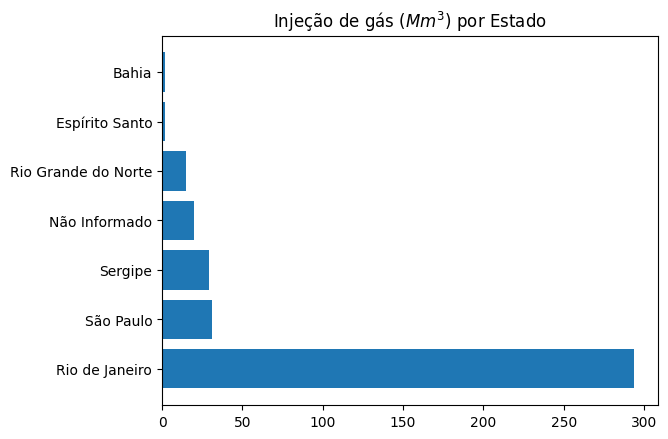

('Rio de Janeiro', 294)
('São Paulo', 31)
('Sergipe', 29)
('Não Informado', 20)
('Rio Grande do Norte', 15)
('Espírito Santo', 2)
('Bahia', 2)


In [ ]:
Um métodartificialonde injetam gás pro petróleo ou água  imergir, ele é chamado de gás lift
Baseia-se na injeção de gás a alta pressão na coluna de produção com o objetivo de gaseificar o fluido produzido, o que provoca aumento da vazão,
tendo  vários estudos e métodos sobre a equação perfeita para cada tipo de profundidade e poço,

os materiais de injeção variam entre gases de densidade menor que ar, além de vapor de água, bolhas de ar comprimido entre outros,

reinjeção aumenta e dependendo do caso até 30% da produção de petróleo

a = cursor.execute("""
SELECT
    E.nome_estado AS ESTADO,
    COUNT(DISTINCT P.id_poco) AS QTD_POÇOS_MARITIMOS
FROM Campo C
NATURAL JOIN Poco P
NATURAL JOIN Estado E
NATURAL JOIN Producao PR
WHERE PR.gas_inj_prod > 0 AND PR.gas_inj_prod IS NOT NULL AND P.ambiente_poco = 'Mar'
GROUP BY E.nome_estado
ORDER BY QTD_POÇOS_MARITIMOS DESC;
""")

a = list(a)
plt.title("Injeção de gás ($Mm^3$) por Estado")
plt.barh([t[0] for t in a], [t[1] for t in a])
plt.show()
for row in a:
  print(row)

# 7. Autoavaliação dos membros
Essa autoavaliação será feita com a descrição do que cada membro contribuiu para o trabalho seguida por uma nota de 0 a 5 dada pelo membro julgando sua participação nesse.


Elias - Esquematização do banco, idealização e desenvolvimento das consultas. 5/5

Paula - Idealização e desenvolvimento das consultas. 5/5

Pedro - Construção do Banco, organização de seus arquivos e desenvolvimento de consultas. 5/5

Rubens - Esquematização do banco, normalização dos dados, idealização e desenvolvimento das consultas. 5/5
